In [ ]:
%%capture
!pip install wandb

In [ ]:
import pandas as pd
from transformers import pipeline
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
root_folder = "gdrive/MyDrive/emotion_recognition/"
data_path = root_folder + "data_init/"
data_seg_path = root_folder + "data_init_segments/"
res_folder = root_folder + 'experiments/'
audio_features_folder = res_folder + "audio_features/"
text_features_folder = res_folder + "text_features/"

# Helper Functions

In [ ]:
import wandb
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

def evaluate(y_true, y_pred, run, display_cm=True, display_cr=True):
    # print(f"f1-score: {round(f1_score(y_true, y_pred, average='binary'),2)}, accuracy: {round(accuracy_score(y_true, y_pred),2)}")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    if display_cm:
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot()
      plt.show()

    if display_cr:
      cr = classification_report(y_true, y_pred)
      print(cr)

    if run:
      wandb.sklearn.plot_confusion_matrix(y_true, y_pred)

      cr = classification_report(y_true, y_pred, output_dict=True)
      run.log({"accuracy" : cr['accuracy'],
              "no_conflict_precision" : cr['no-conflict']['precision'],
              "no_conflict_recall" : cr['no-conflict']['recall'],
              "no_conflict_f1-score" : cr['no-conflict']['f1-score'],
              "conflict_precision" : cr['conflict']['precision'],
              "conflict_recall" : cr['conflict']['recall'],
              "conflict_f1-score" : cr['conflict']['f1-score']})

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import time


def cross_validation_n_fold(clf, values, true_labels, wandb_config=None, cv=5):
  run = None
  if wandb_config:
    timestr = time.strftime("%m%d-%H%M")
    run = wandb.init(project="emotion_recognition",
              name=f"e_{timestr}_audio_eval",
              config=wandb_config)

  # score = cross_val_score(clf, values, true_labels, cv=5)

  pred = cross_val_predict(clf, values, true_labels, cv=5)

  evaluate(true_labels, pred, run)

  if wandb_config:
    wandb.finish()
  # print(score)
  # print(confusion_matrix(true_labels, pred))
  # print(classification_report(true_labels, pred))

In [ ]:
def fold_i_of_k(meta_df, seg_features, i, k):
    n = len(meta_df)

    return meta_df[n*(i-1)//k:n*i//k]


def manual_k_fold(clf, df_seg, df_seg_features, name='pred_compare_func', wandb_config=None, cv=5):
  run=None
  if wandb_config:
    timestr = time.strftime("%m%d-%H%M")
    run = wandb.init(project="emotion_recognition",
              name=f"e_{timestr}_audio_eval",
              config=wandb_config)

  for i in range(1, cv+1):
    fold_i_of_k(df_file, df_seg, i, cv)
    k_fold = df_seg[df_seg['conversation_folder_name'].isin(fold_i_of_k(df_file, df_seg, i, cv).folder_name)]
    features_test = df_seg_features[df_seg_features['path'].isin(k_fold.path)].copy()
    features_train = df_seg_features[~df_seg_features['path'].isin(k_fold.path)].copy()

    clf.fit(features_train.drop(columns=['path', 'label']),
                  features_train['label'])
    try:
      pred = clf.predict(features_test.drop(columns=['path', 'label']))
    except:
      display(features_test)

    df_seg.loc[k_fold.index, name] = pred
  print(df_seg[name].value_counts())
  df_res = df_seg[['conversation_folder_name', 'context_label', 'label', name]] \
            .groupby(['conversation_folder_name', 'context_label'])[name] \
            .apply(lambda x: 'conflict' if 'conflict' in list(x.values) else 'no-conflict').reset_index()

  evaluate(df_res['context_label'], df_res[name], run=run)


  if wandb_config:
    run.finish()

In [ ]:
wandb.login()

wandb_config = {
    "model_name" : "",
    "fine-tuned" : False,
    "framework" : "sklearn",
    "data" : "init_full_1h",
    "feature_set" : "ComParE_2016",
    "feature_level" : "func",
    "task" : "audio_classification",
    "split" : "no",
    "CV" : "n-fold"
}

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Data preparation

In [ ]:
df_file = pd.read_csv(res_folder+'latest.csv', ).reset_index(drop=True)

df_file['emotion_merged'] = df_file['emotion']
df_file.loc[df_file['emotion_merged'] == 'pleasant_surprise', 'emotion_merged'] = 'happy'
df_file.loc[df_file['emotion_merged'] == 'disgust', 'emotion_merged'] = 'angry'
df_file['label'] = df_file['emotion_merged'].apply(lambda x: 'no-conflict' if x in ['neutral', 'happy'] else 'conflict')
df_file['path'] = data_path + df_file['folder_name'] + '/' + "rs_16_" + df_file['audio_file_name']
df_file['folder'] = df_file.path.str.split('/').str[4]

df_file = df_file.drop(columns=['Unnamed: 0', 'emotion'])

# Feature extraction

In [ ]:
def get_features_df(text, labels, path, feature_extractor, model_name=None, prefix=""):
  # [print(len(t)) for t in list(text)]
  pipline_out = feature_extractor(list(text) ,return_tensors = "pt", )
  pipline_out_df = pd.DataFrame([torch.mean(item, dim=1)[0].numpy() for item in pipline_out],
                                columns=['hs_'+str(i) for i in range(pipline_out[0].shape[-1])])

  pipline_out_df['path'] = path
  pipline_out_df['label'] = labels

  if model_name:
    print(f"saving features to {text_features_folder + prefix + model_name.split('/')[1] + '.csv'}")
    pipline_out_df.to_csv(text_features_folder + prefix + model_name.split('/')[1] + '.csv')

  return pipline_out_df

In [ ]:
feature_extractor = pipeline("feature-extraction", framework="pt", model="microsoft/mdeberta-v3-base")


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



In [ ]:
roberta_pipline_twitter_out_eng_df = get_features_df(df_file['openai/whisper-large-v2_transc'], df_file.label, df_file.path,
                                                     feature_extractor=feature_extractor,
                                                     model_name="microsoft/mdeberta-v3-base",
                                                     prefix="transc_file_original_")

saving features to gdrive/MyDrive/emotion_recognition/experiments/text_features/transc_file_original_mdeberta-v3-base.csv


In [ ]:

feature_extractor = pipeline("feature-extraction", framework="pt", model="FacebookAI/roberta-base")
roberta_pipline_twitter_out_eng_df = get_features_df(df_file['openai/whisper-large-v2_translate'], df_file.label, df_file.path,
                                                     feature_extractor=feature_extractor,
                                                     model_name="FacebookAI/roberta-base",
                                                     prefix="transl_file_original_")


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

saving features to gdrive/MyDrive/emotion_recognition/experiments/text_features/transl_file_original_roberta-base.csv


In [ ]:
feature_extractor = pipeline("feature-extraction", framework="pt", model="cardiffnlp/twitter-roberta-base-sentiment-latest")


In [ ]:
roberta_pipline_twitter_out_eng_df = get_features_df(df_file['openai/whisper-large-v2_translate'], df_file.label, df_file.path,
                                                     feature_extractor=feature_extractor,
                                                     model_name="cardiffnlp/twitter-roberta-base-sentiment-latest",
                                                     prefix="transl_file_")

saving features to gdrive/MyDrive/emotion_recognition/experiments/text_features/transl_file_twitter-roberta-base-sentiment-latest.csv


# Evaluation

## twitter-roberta-base-sentiment-latestv - eng - LR

wandb: Currently logged in as: patenko-pn (lp-ucu). Use `wandb login --relogin` to force relogin


[[39  5]
 [ 9 37]]


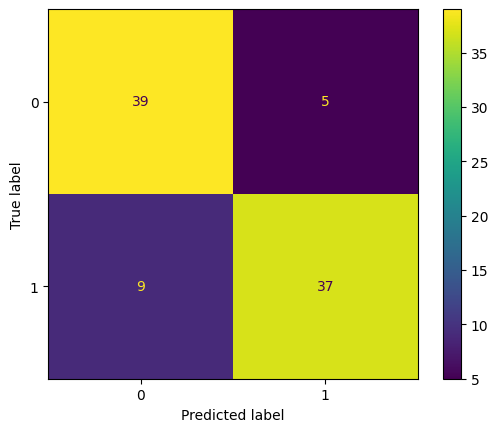

              precision    recall  f1-score   support

    conflict       0.81      0.89      0.85        44
 no-conflict       0.88      0.80      0.84        46

    accuracy                           0.84        90
   macro avg       0.85      0.85      0.84        90
weighted avg       0.85      0.84      0.84        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.84444
conflict_f1-score,0.84783
conflict_precision,0.8125
conflict_recall,0.88636


In [ ]:
from sklearn.linear_model import LogisticRegression


wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "whisper-large-v2_translate"
wandb_config['data'] = "init_full_1h"
wandb_config['split'] = "no"
wandb_config['feature_set'] = 'twitter-roberta-base-sentiment-latest'
wandb_config['task'] = "text_classification"


clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0),
)

cross_validation_n_fold(clf, roberta_pipline_twitter_out_eng_df.loc[:,'hs_0':'hs_767'],
               roberta_pipline_twitter_out_eng_df['label'], wandb_config)

## roberta-base-go_emotions - eng - LR

In [ ]:
feature_extractor = pipeline("feature-extraction", framework="pt", model="SamLowe/roberta-base-go_emotions")


Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
roberta_pipline_emotions_out_eng_df = get_features_df(df_file['openai/whisper-large-v2_translate'], df_file.label, df_file.path,
                                                      feature_extractor=feature_extractor,
                                                      model_name="SamLowe/roberta-base-go_emotions",
                                                      prefix="transl_file_")

saving features to gdrive/MyDrive/emotion_recognition/experiments/text_features/transl_file_roberta-base-go_emotions.csv


[[34 10]
 [ 6 40]]


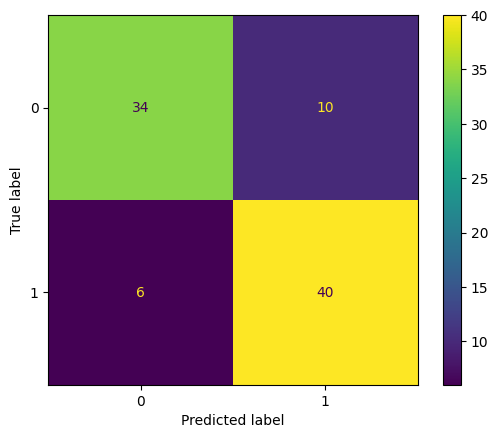

              precision    recall  f1-score   support

    conflict       0.85      0.77      0.81        44
 no-conflict       0.80      0.87      0.83        46

    accuracy                           0.82        90
   macro avg       0.82      0.82      0.82        90
weighted avg       0.82      0.82      0.82        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.82222
conflict_f1-score,0.80952
conflict_precision,0.85
conflict_recall,0.77273


In [ ]:
from sklearn.linear_model import LogisticRegression


wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "whisper-large-v2_translate"
wandb_config['data'] = "init_full_1h"
wandb_config['split'] = "no"
wandb_config['feature_set'] = 'roberta-base-go_emotions'
wandb_config['task'] = "text_classification"


clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0),
)

cross_validation_n_fold(clf, roberta_pipline_emotions_out_eng_df.loc[:,'hs_0':'hs_767'],
               roberta_pipline_emotions_out_eng_df['label'], wandb_config)

## mDeBERTa-v3-base-mnli-xnli

In [ ]:
feature_extractor = pipeline("feature-extraction", framework="pt", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")

config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [ ]:
mdeberta_pipline_out_df = get_features_df(df_file['openai/whisper-large-v2_translate'], df_file.label, df_file.path,
                                          model_name="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
                                          prefix="transl_file_")

saving features to gdrive/MyDrive/emotion_recognition/experiments/text_features/transl_file_mDeBERTa-v3-base-mnli-xnli.csv


In [ ]:
_ = get_features_df(df_file['openai/whisper-large-v2_transc'], df_file.label, df_file.path,
                                          feature_extractor=feature_extractor,
                                          model_name="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
                                          prefix="transc_file_")

saving features to gdrive/MyDrive/emotion_recognition/experiments/text_features/transc_file_mDeBERTa-v3-base-mnli-xnli.csv


In [ ]:
_ = get_features_df(df_file['origin_text'], df_file.label, df_file.path,
                                          feature_extractor=feature_extractor,
                                          model_name="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
                                          prefix="origin_file_")

saving features to gdrive/MyDrive/emotion_recognition/experiments/text_features/origin_file_mDeBERTa-v3-base-mnli-xnli.csv


### eng - LR

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[25 19]
 [12 34]]


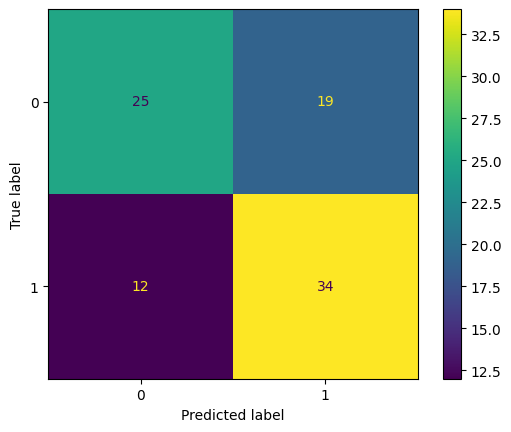

              precision    recall  f1-score   support

    conflict       0.68      0.57      0.62        44
 no-conflict       0.64      0.74      0.69        46

    accuracy                           0.66        90
   macro avg       0.66      0.65      0.65        90
weighted avg       0.66      0.66      0.65        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.65556
conflict_f1-score,0.61728
conflict_precision,0.67568
conflict_recall,0.56818


In [ ]:
from sklearn.linear_model import LogisticRegression

wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "openai/whisper-large-v2_translate"
wandb_config['data'] = "init_full_1h"
wandb_config['split'] = "no"
wandb_config['feature_set'] = 'mDeBERTa-v3-base-mnli-xnli'
wandb_config['task'] = "text_classification"

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0),
)

cross_validation_n_fold(clf, mdeberta_pipline_out_df.loc[:,'hs_0':'hs_767'],
               mdeberta_pipline_out_df['label'], wandb_config)

### ukr_ru transcribtion - LR

In [ ]:
roberta_pipline_out_transc_df = get_features_df(df_file['openai/whisper-large-v2_transc'], df_file.label, df_file.path)


[[33 11]
 [15 31]]


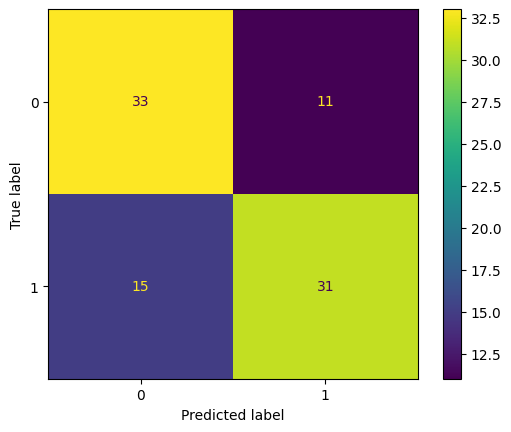

              precision    recall  f1-score   support

    conflict       0.69      0.75      0.72        44
 no-conflict       0.74      0.67      0.70        46

    accuracy                           0.71        90
   macro avg       0.71      0.71      0.71        90
weighted avg       0.71      0.71      0.71        90



In [ ]:
from sklearn.linear_model import LogisticRegression


# wandb_config['model_name'] = "LR"
# wandb_config['feature_level'] = "extract_features"
# wandb_config['data'] = "init_full_1h"
# wandb_config['split'] = "no"
# wandb_config['feature_set'] = 'w2v2-fb-xlsr-300m-no-tune'

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0),
)

cross_validation_n_fold(clf, roberta_pipline_out_transc_df.loc[:,'hs_0':'hs_767'],
               roberta_pipline_out_transc_df['label'], None)

## twitter-roberta-base-sentiment-latest - eng - LSTM

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

class SentimentLSTM(nn.Module):
  def __init__(self, embedding_dim, output_dim, hidden_size=128):
    super(SentimentLSTM, self).__init__()
    self.lstm = nn.LSTM(embedding_dim, hidden_size)
    self.fc = nn.Linear(hidden_size, output_dim)

  def forward(self, x):
    x, _ = self.lstm(x)

    #out = self.fc(x[:, -1, :])
    out = self.fc(x)
    return out

def train(model, train_loader, optimizer, criterion):
  model.train()
  total_loss = 0
  correct = 0
  total = 0
  for data, target in train_loader:
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()
  train_loss = total_loss / len(train_loader)
  train_acc = 100 * correct / total
  return train_loss, train_acc

def evaluate(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  total_loss = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      loss = criterion(output, target)  # Calculate validation loss here
      total_loss += loss.item()
      _, predicted = torch.max(output.data, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
  valid_acc = 100 * correct / total
  valid_loss = total_loss / len(test_loader)
  return valid_loss, valid_acc

def kfold_cv(model, X, y, k, embedding_dim, optimizer, criterion, num_epochs=5, batch_size=32):
  # KFold for splitting data
  kf = KFold(n_splits=k, shuffle=True, random_state=0)
  cv_train_losses, cv_train_accs, cv_val_accs = [], [], []
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

    print()
    for epoch in range(num_epochs):
      train_loss, train_acc = train(model, train_loader, optimizer, criterion)
      val_loss, val_acc = evaluate(model, test_loader)
      print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    cv_train_losses.append(train_loss)
    cv_train_accs.append(train_acc)
    cv_val_accs.append(val_acc)

  print(f"\nAverage Train Loss: {sum(cv_train_losses) / len(cv_train_losses):.4f}")
  print(f"Average Train Acc: {sum(cv_train_accs) / len(cv_train_accs):.2f}%")
  print(f"Average Val Acc: {sum(cv_val_accs) / len(cv_val_accs):.2f}%")
  return cv_train_losses, cv_train_accs, cv_val_accs



In [ ]:
# Example usage (replace with your data loaders)
embedding_dim = 768
model = SentimentLSTM(embedding_dim, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
k = 5  # Number of folds for cross-validation


X = torch.tensor(roberta_pipline_twitter_out_eng_df.drop(columns=['path', 'label']).values)
y = torch.tensor(roberta_pipline_twitter_out_eng_df['label'].factorize()[0])


# Assuming X is your pre-extracted embeddings and y are labels
_, _, _ = kfold_cv(model.to('cpu'), X.to('cpu'), y.to('cpu'), k, embedding_dim, optimizer, criterion, num_epochs=15, batch_size=4)



Epoch: 1, Train Loss: 0.6631, Val Loss: 0.5905, Train Acc: 56.94%, Val Acc: 72.22%
Epoch: 2, Train Loss: 0.6014, Val Loss: 0.5622, Train Acc: 65.28%, Val Acc: 77.78%
Epoch: 3, Train Loss: 0.5276, Val Loss: 0.4986, Train Acc: 79.17%, Val Acc: 83.33%
Epoch: 4, Train Loss: 0.4832, Val Loss: 0.4803, Train Acc: 79.17%, Val Acc: 77.78%
Epoch: 5, Train Loss: 0.4191, Val Loss: 0.4212, Train Acc: 84.72%, Val Acc: 83.33%
Epoch: 6, Train Loss: 0.3904, Val Loss: 0.3980, Train Acc: 83.33%, Val Acc: 77.78%
Epoch: 7, Train Loss: 0.3550, Val Loss: 0.3395, Train Acc: 86.11%, Val Acc: 88.89%
Epoch: 8, Train Loss: 0.3173, Val Loss: 0.3135, Train Acc: 87.50%, Val Acc: 88.89%
Epoch: 9, Train Loss: 0.2727, Val Loss: 0.2925, Train Acc: 88.89%, Val Acc: 88.89%
Epoch: 10, Train Loss: 0.2547, Val Loss: 0.2625, Train Acc: 91.67%, Val Acc: 88.89%
Epoch: 11, Train Loss: 0.2139, Val Loss: 0.2509, Train Acc: 93.06%, Val Acc: 88.89%
Epoch: 12, Train Loss: 0.2041, Val Loss: 0.2181, Train Acc: 91.67%, Val Acc: 94.44%
